# RSI model-05 ( Regression approach )
https://chatgpt.com/c/67ff8405-7cfc-800a-b166-c9137db53451

In [14]:
# Cell 2: Imports and Hyperparameters
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from ta.momentum import RSIIndicator

# Hyperparameters (you can modify)
rsi_period = 14
buy_zone = 30
sell_zone = 70
input_window = 30
future_window = 100

In [20]:
# Cell 3: Load and preprocess the training data
def load_and_preprocess(filepath):
    df = pd.read_csv(filepath, sep="\t")
    df.columns = df.columns.str.strip()  # Clean headers
    df = df[['<OPEN>', '<HIGH>', '<LOW>', '<CLOSE>']].copy()
    df.dropna(inplace=True)
    return df

train_df = load_and_preprocess("../datasets/XAGUSD-H1-rates.csv")


In [25]:
# Cell 4: Add RSI and normalize features
def add_rsi(df):
    rsi = RSIIndicator(close=df['<CLOSE>'], window=rsi_period).rsi()
    df['<RSI>'] = rsi
    return df.dropna()

train_df = add_rsi(train_df)

# Normalize
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(train_df[['<OPEN>', '<HIGH>', '<LOW>', '<CLOSE>', '<RSI>']])


In [26]:
# Cell 5: Create sliding window dataset for training
def create_dataset(data, input_window, future_window):
    X, y = [], []
    for i in range(len(data) - input_window - future_window):
        X.append(data[i:i+input_window])
        y.append(data[i+input_window:i+input_window+future_window, 3])  # index 3 = normalized CLOSE
    return np.array(X), np.array(y)

X_train, y_train = create_dataset(scaled_features, input_window, future_window)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)


X_train shape: (54901, 30, 5)
y_train shape: (54901, 100)


In [27]:
# Cell 6: Build the regression model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(input_window, X_train.shape[2])),
    tf.keras.layers.LSTM(64, return_sequences=False),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(future_window)
])

model.compile(optimizer='adam', loss='mse')
model.summary()


I0000 00:00:1744814208.585605    4256 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2064 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        12,900 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,140 (152.89 KB)

 Trainable params: 39,140 (152.89 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
# Cell 7: Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.1)


Epoch 1/10


I0000 00:00:1744814220.531375    6757 cuda_dnn.cc:529] Loaded cuDNN version 90800


773/773 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0175 - val_loss: 0.0011
Epoch 2/10
773/773 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 8.4593e-04 - val_loss: 0.0011
Epoch 3/10
773/773 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 8.3621e-04 - val_loss: 0.0011
Epoch 4/10
773/773 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 8.4219e-04 - val_loss: 0.0016
Epoch 5/10
773/773 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 8.6942e-04 - val_loss: 0.0013
Epoch 6/10
773/773 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 8.5164e-04 - val_loss: 0.0012
Epoch 7/10
773/773 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 8.3004e-04 - val_loss: 0.0012
Epoch 8/10
773/773 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 8.3749e-04 - val_loss: 0.0012
Epoch 9/10
773/773 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 8.4923e-04 - val_loss: 0.0011
Epoch 10/10
773/773 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 8.0868e-04 - val_loss: 0.0011


In [31]:
# Cell 8: Load and preprocess the latest 30 candles for prediction
test_df = load_and_preprocess("../datasets/new-data-for-test/rows-30-from-20240503.csv")
test_df = add_rsi(test_df)
scaled_test = scaler.transform(test_df[['<OPEN>', '<HIGH>', '<LOW>', '<CLOSE>', '<RSI>']])
X_input = np.expand_dims(scaled_test[-input_window:], axis=0)  # shape (1, 30, features)


In [32]:
# Cell 9: Predict 100 future CLOSE prices
predicted_normalized = model.predict(X_input)[0]
predicted_close = scaler.inverse_transform(
    np.hstack([np.zeros((future_window, 4)), predicted_normalized.reshape(-1, 1)])
)[:, -1]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


In [34]:
# Cell 10: Combine actual + predicted CLOSE prices, compute RSI and signals
# Create fake OHLC to compute RSI (use CLOSE as proxy)
predicted_df = pd.DataFrame({
    '<CLOSE>': predicted_close,
    '<OPEN>': predicted_close,
    '<HIGH>': predicted_close,
    '<LOW>': predicted_close
})
predicted_df = add_rsi(predicted_df)

combined_close = pd.concat([test_df[['<CLOSE>']], predicted_df[['<CLOSE>']]], ignore_index=True)
combined_rsi = pd.concat([test_df[['<RSI>']], predicted_df[['<RSI>']]], ignore_index=True)

# Generate reversal signals
def get_reversal_signals(rsi_series):
    signals = []
    for rsi in rsi_series:
        if rsi < buy_zone:
            signals.append(1)
        elif rsi > sell_zone:
            signals.append(2)
        else:
            signals.append(0)
    return signals

signals = get_reversal_signals(combined_rsi['<RSI>'])


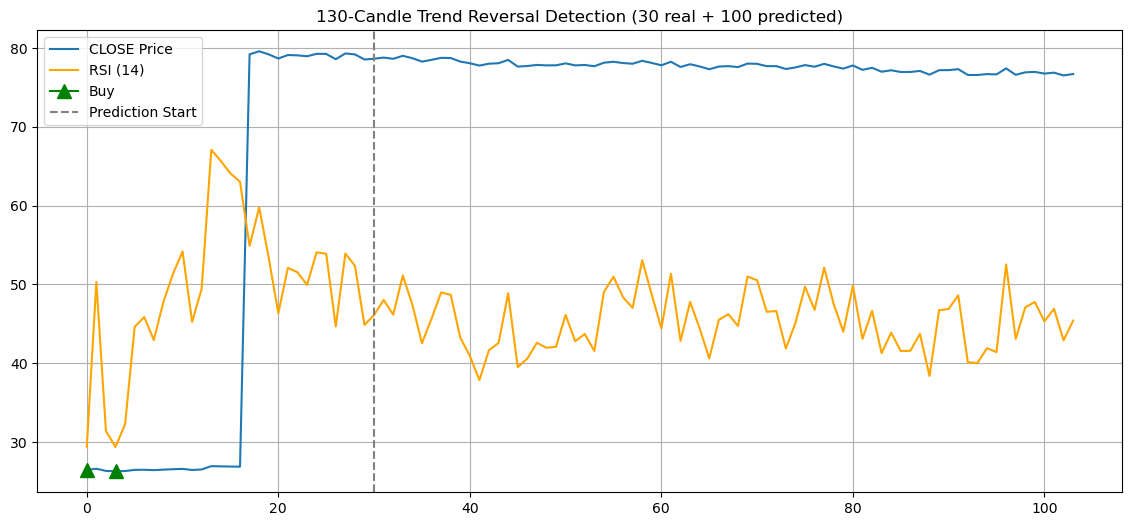

In [35]:
# Cell 11: Plot results
plt.figure(figsize=(14, 6))
plt.plot(combined_close, label='CLOSE Price')
plt.plot(combined_rsi, label=f'RSI ({rsi_period})', color='orange')

# Mark reversal points
for i, signal in enumerate(signals):
    if signal == 1:
        plt.plot(i, combined_close.iloc[i], marker='^', color='green', markersize=10, label='Buy' if i==0 else "")
    elif signal == 2:
        plt.plot(i, combined_close.iloc[i], marker='v', color='red', markersize=10, label='Sell' if i==0 else "")

plt.axvline(x=input_window, color='gray', linestyle='--', label='Prediction Start')
plt.title("130-Candle Trend Reversal Detection (30 real + 100 predicted)")
plt.legend()
plt.grid(True)
plt.show()
